In [35]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [46]:
ssn = pd.read_csv('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv')
ssn['date'] = pd.to_datetime(ssn[['year', 'month']].assign(DAY=1))
ssn = ssn.drop(columns=['year', 'month'], axis=1)

In [47]:
def prepare_for_prophet(df, value_col):
    prophet_df = df.rename(columns={'date': 'ds', value_col: 'y'})
    return prophet_df[['ds', 'y']]

In [55]:
def create_prophet_model(df, cycle_period=11):
    m = Prophet(
        seasonality_mode='multiplicative',  
        yearly_seasonality=False,           
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.0001,
        interval_width=0.90,
    )
    
    m.add_seasonality(
        name='solar_cycle',
        period=365.25 * cycle_period,  # Convert years to days
        fourier_order=5,
    )
    
    m.fit(df)
    return m

In [56]:
def make_forecast(model, periods=72, freq='MS'):
    # Create future dataframe (6 years monthly)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    forecast = model.predict(future)
    
    return forecast

In [57]:
def calculate_metrics(original_data, forecast, start_date=None):
    # Merge forecast with original data
    merged = pd.merge(
        original_data, 
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
        left_on='ds', 
        right_on='ds', 
        how='inner'
    )
    
    if start_date:
        merged = merged[merged['ds'] >= start_date]
    
    if len(merged) == 0:
        return {'picp': None, 'mpiw': None}
    
    # PICP (prediction interval coverage probability
    within_pi = ((merged['y'] >= merged['yhat_lower']) & 
                 (merged['y'] <= merged['yhat_upper']))
    picp = within_pi.mean() * 100
    
    # MPIW (mean prediction interval width)
    mpiw = (merged['yhat_upper'] - merged['yhat_lower']).mean()
    
    return {'picp': picp, 'mpiw': mpiw}

In [58]:
def plot_solar_cycle_forecast(original_data, forecast, title, y_label, 
                             cycle_25_start='2020-01-01', 
                             plot_start='2010-01-01', 
                             plot_end='2030-12-31',
                             latest_data_date=None):
    
    plt.figure(figsize=(12, 8))
    
    # Filter data for plotting period
    mask_period = (forecast['ds'] >= plot_start) & (forecast['ds'] <= plot_end)
    plot_forecast = forecast[mask_period]
    
    # Filter original data for plotting period
    mask_orig = (original_data['ds'] >= plot_start) & (original_data['ds'] <= plot_end)
    plot_original = original_data[mask_orig]
    
    # Plot uncertainty interval (only from cycle 25 onwards)
    mask_c25 = (plot_forecast['ds'] >= cycle_25_start)
    plt.fill_between(
        plot_forecast.loc[mask_c25, 'ds'],
        plot_forecast.loc[mask_c25, 'yhat_lower'],
        plot_forecast.loc[mask_c25, 'yhat_upper'],
        color='lightblue', alpha=0.5,
        label='Uncertainty Interval'
    )
    
    # Plot the forecast line for the entire period
    plt.plot(plot_forecast['ds'], plot_forecast['yhat'], 
             color='steelblue', linewidth=2, label='Forecast')
    
    # Plot historical data as dots
    plt.scatter(plot_original['ds'], plot_original['y'], 
                color='black', s=10, alpha=0.7, label='Historical Sunspots')
    
    # Add vertical line for the latest data point
    if latest_data_date:
        plt.axvline(x=pd.to_datetime(latest_data_date), color='red', 
                   linestyle='--', linewidth=2, label='Latest Data')
    
    plt.axvspan(pd.to_datetime(cycle_25_start), pd.to_datetime(plot_end),alpha=0.1, color='yellow', label='Solar Cycle 25')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    ax = plt.gca()
    ax.xaxis.set_major_locator(YearLocator(5))  # Show year every 5 years
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.xticks(rotation=0, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', fontsize=12)
    
    plt.tight_layout()
    return plt

In [59]:
ssn_prophet = prepare_for_prophet(ssn, 'ssn')

ssn_model = create_prophet_model(ssn_prophet)

ssn_forecast = make_forecast(ssn_model)

09:37:32 - cmdstanpy - INFO - Chain [1] start processing
09:37:32 - cmdstanpy - INFO - Chain [1] done processing
09:37:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:37:32 - cmdstanpy - INFO - Chain [1] start processing
09:37:37 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
cycle_25_start = '2020-01-01'
latest_data_date = '2024-07-01'

ssn_metrics = calculate_metrics(ssn_prophet, ssn_forecast, start_date=cycle_25_start)

# Print metrics
print("SSN Forecast Metrics for Cycle 25 (historical portion):")
print(f"PICP: {ssn_metrics['picp']:.2f}%") 
print(f"MPIW: {ssn_metrics['mpiw']:.2f}")

SSN Forecast Metrics for Cycle 25 (historical portion):
PICP: 100.00%
MPIW: 177.82


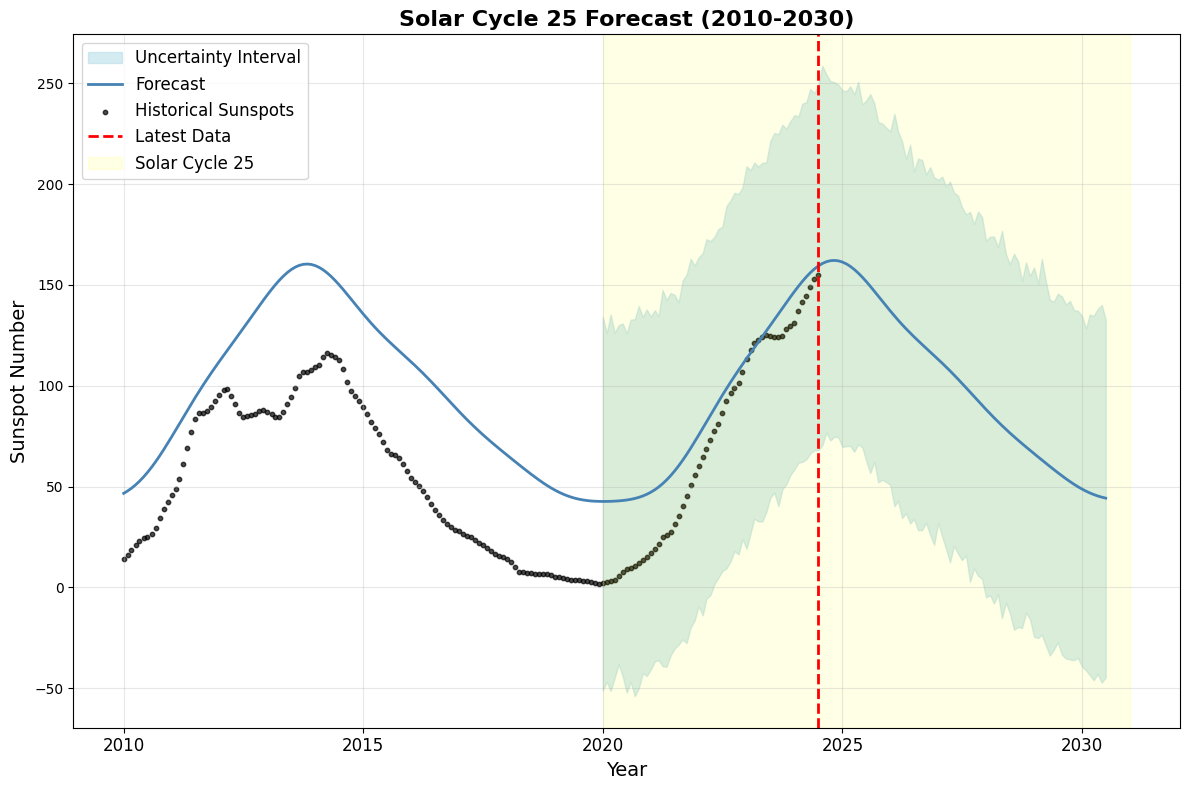

In [61]:
ssn_plot = plot_solar_cycle_forecast(
    ssn_prophet, ssn_forecast, 
    'Solar Cycle 25 Forecast (2010-2030)', 
    'Sunspot Number',
    cycle_25_start=cycle_25_start,
    plot_start='2010-01-01',
    plot_end='2030-12-31',
    latest_data_date=latest_data_date
)
ssn_plot.show()

In [62]:
cycle_25_data = ssn_forecast[(ssn_forecast['ds'] >= cycle_25_start) & 
                            (ssn_forecast['ds'] <= '2030-12-31')]

# Find the row with the maximum value
max_row = cycle_25_data.loc[cycle_25_data['yhat'].idxmax()]
peak_date = max_row['ds']
peak_value = max_row['yhat']
peak_lower = max_row['yhat_lower']
peak_upper = max_row['yhat_upper']

print(f"\nSolar Cycle 25 Peak Prediction:")
print(f"Predicted peak date: {peak_date.strftime('%B %Y')}")
print(f"Predicted peak sunspot number: {peak_value:.1f}")
print(f"90% confidence interval: [{peak_lower:.1f}, {peak_upper:.1f}]")


Solar Cycle 25 Peak Prediction:
Predicted peak date: November 2024
Predicted peak sunspot number: 162.1
90% confidence interval: [74.8, 250.4]
